<a href="https://colab.research.google.com/github/fabfaba/DiffusionCLIP_fab/blob/master/diffusionclip_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enjoy DiffusionCLIP: Text-Guided Diffusion Models for __Robust__ Image Manipulation

<a href="https://colab.research.google.com/drive/1n50M3cEGyU6O1DyB791fz43RwnbavPS4?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We provide a colab notebook for you to play with DiffusionCLIP! Due to 12GB of the VRAM limit in Colab, we only provide the codes of inference & applications with the fine-tuned DiffusionCLIP models, not fine-tuning code. We provide a wide range of types of edits, and you can also upload your fine-tuned models following below instructions on Colab and test them.
- __Note: Due to the low performance of NVIDIA K80 GPU that is provided for free on Colab, foward-reverse processes can be slow. If RTX 2080ti or Quardro RTX 6000 are used, the processes can be accelerated as 10 times.__

# Setup
- This will install required packages and take a few minutes.
- __Pydrive__ enable to avoid Google Drive download limit but it takes more time when using it. If you have trouble with download limit, please run the notebook again and run setup with checking `download_with_pydrive`.

In [ ]:
#@title Setup
import os
diffusionclip_dir = os.path.join("/content", "DiffusionCLIP")
from getpass import getpass

! git clone https://github.com/gwang-kim/DiffusionCLIP.git
os.chdir(f'./DiffusionCLIP')
os.makedirs("checkpoint", exist_ok=True)
os.makedirs("precomputed", exist_ok=True)
os.makedirs("pretrained", exist_ok=True)
os.makedirs("runs", exist_ok=True)

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

from utils.colab_utils import GoogleDrive_Dowonloader
download_with_pydrive = False #@param {type:"boolean"}
dl = GoogleDrive_Dowonloader(download_with_pydrive)


from diffusionclip import DiffusionCLIP
from main import dict2namespace
import argparse
import yaml
from PIL import Image
import warnings
warnings.filterwarnings(action='ignore')

device = 'cuda'

%load_ext autoreload
%autoreload 2

# Manipulation of Images in Trained Domain & to Unseen Domain
You can edit one image into the CLIP-guided domain.
- Use the image path of samples in `./imgs` or use your uploaded image.
- We provide a wide range of `edit_type`, but you can also use your finetuned models by uploadint them in `./checkpoint`.
- You can control the degree of change by controling `degree_of_change` from 0.0 (no change) to 1.0 (full change).
- `n_inv_step` can be chosen in `[0, t_0]` where `t_0` is set depending on the finetuned models automatically  e.g. 4 ~ 200
- `n_test_step` can be chosen in `[0, n_inv_step]` e.g. 6, 12 for quick manipulation.
  - We found that the manipulation quality is better when n_***_step does not divide t_0. So we usally use 301, 401, 500 or 601 for t_0.
- Image is inverted to the latent once for each image at the first time. From the next time, the image is generated from the latent without the inversion.
- You can use your finetuned models by uploading them in `./checkpoint`.
- The models are downloaded once.
- The latent for the same image and `t_0` is calculated once.


pretrained/512x512_diffusion.pt exists.
Finished
return step t_0: 500
None is loaded.
checkpoint/tennis_baseball_t500.pth is loaded.
Latent exists.
Sampling type: DDIM with eta 0.0,  Steps: 12/500
Uniform skip type


Generative process 0: 100%|██████████| 12/12 [00:36<00:00,  3.07s/it]


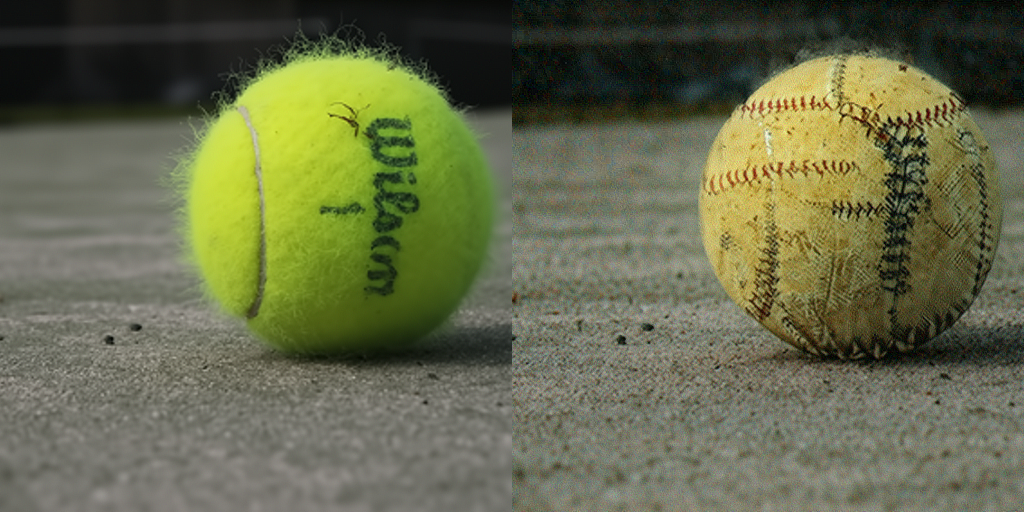

In [ ]:
#@title Tennis Ball Manipulation (512x512)
#@markdown DiffusionCLIP can even perform manipulation of __512 × 512 images using the ImageNet__ pretrained diffusion models.
#@markdown Thanks to the near-perfect inversion capability, DiffusionCLIP enables the zero-shot text-driven manipulation, moving a step forward to the __general text-driven manipulation__.

#@markdown In contrast, due to the diversity of the images in ImageNet, __GAN-based inversion and its manipulation in the latent space of ImageNet shows limited performance__. Hence, zero-shot text-driven manipulation using ImageNet pretrained GAN have been rarely explored.

#@markdown You can use `imgs/tennis1.png`\~`imgs/tennis4.png` as `img_path`.

if not os.path.exists('pretrained/512x512_diffusion.pt'):
  ! wget -P pretrained/ https://openaipublic.blob.core.windows.net/diffusion/jul-2021/512x512_diffusion.pt
else:
  print('pretrained/512x512_diffusion.pt exists.')



img_path = 'imgs/tennis1.png'  #@param {type:"string"}
edit_type = 'Baseball' #@param ['Baseball', 'Melon','Orange', 'Tomato']
degree_of_change = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
tennis_gdrive_ids = {'Baseball':   ["1yGLsrGWkJJ9bRprBYLs8SQDzYG0x6yc1", "tennis_baseball_t500.pth"],
                     'Melon':      ["1-nGdHZ8sfyePQmOMRXV-c1yr8qHxFIdO", "tennis_melon_t500.pth"],
                     'Orange':     ["1tyTTs2NuObhHbll9f6-mGQH1-4Mi0VG5", "tennis_orange_t500.pth"],
                     'Tomato':     ["1iZOXEf8oZON1w_5p6a8Wh1AJRcvtfYEC", "tennis_tomato_t500.pth"],
                    }

gid = tennis_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', tennis_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40 #@param {type: "integer"}
n_test_step = 12 #@param [12]
args_dic = {
    'config': 'imagenet.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0.0,
    'bs_test': 1,
    'model_path': model_path,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': 1,
    'align_face': 0,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(exp_dir, f"3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}_{model_path.split('/')[-1].replace('.pth','')}.png"))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid


Finished
return step t_0: 500


Downloading: "https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/bedroom.ckpt" to /root/.cache/torch/hub/checkpoints/bedroom.ckpt


  0%|          | 0.00/434M [00:00<?, ?B/s]

None is loaded.
checkpoint/princess_t500.pth is loaded.


Inversion process :  98%|█████████▊| 39/40 [00:19<00:00,  1.98it/s]


Sampling type: DDIM with eta 0.0,  Steps: 40/500
Uniform skip type


Generative process 0: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]

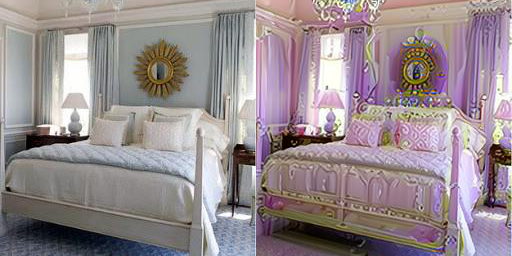

In [ ]:
#@title Bedroom manipulation (256x256)
#@markdown You can use `imgs/bedroom1.png`\~`imgs/bedroom4.png` as `img_path`.

img_path = 'imgs/bedroom1.png'  #@param {type:"string"}
edit_type = 'Princess bedroom' #@param['Princess bedroom', 'Wooden bedroom','Blue tone bedroom', 'Green tone bedroom', 'Watercolor art']
degree_of_change = 1.0 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
bedroom_gdrive_ids = {'Princess bedroom':   ["1gBbyWCDLfBQpoPuNkpc9Ioqu4wJW8o3b", "bedroom_princess_t500.pth"],
                      'Wooden bedroom':     ["1ATF3o7RCSrgi0icwi9HaaZxf2C-DwwTp", "bedroom_wooden_t500.pth"],
                      'Blue tone bedroom':  ["1qAC4ORH5sk3YfXDQ-3QUiXDxMsmJB0g8", "bedroom_blue_t500.pth"],
                      'Green tone bedroom': ["1ClX_LUgpG5igDq0rWTsD7xIzyzGRvge_", "bedroom_green_t601.pth"],
                      'Watercolor art':     ["1ewVadFKi9YLQaaPjqN7UsH6UuEeGX4mf", "bedroom_watercolor_t601.pth"],
                     }


gid = bedroom_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', bedroom_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40 #@param {type: "integer"}
n_test_step = 6 #@param [6]
args_dic = {
    'config': 'bedroom.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0.0,
    'bs_test': 1,
    'model_path': model_path,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': 1,
    'align_face': 0,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(exp_dir, f"3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}_{model_path.split('/')[-1].replace('.pth','')}.png"))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid

Finished
return step t_0: 500


Downloading: "https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/church_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/church_outdoor.ckpt


  0%|          | 0.00/434M [00:00<?, ?B/s]

None is loaded.
checkpoint/ancient_tower_t500.pth is loaded.


Inversion process :  98%|█████████▊| 39/40 [00:19<00:00,  1.97it/s]


Sampling type: DDIM with eta 0.0,  Steps: 40/500
Uniform skip type


Generative process 0: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]

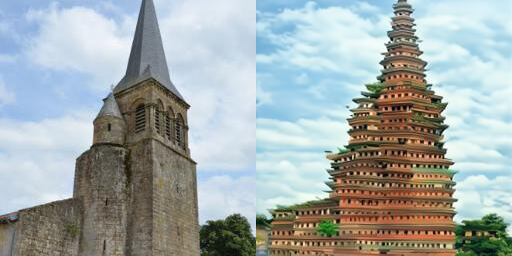

In [ ]:
#@title Church manipulation (256x256)
#@markdown You can use `imgs/church1.png`\~`imgs/church4.png` as `img_path`.

img_path = 'imgs/church1.png'  #@param {type:"string"}
edit_type = 'Asian ancient tower' #@param['Golden church', 'Red brick church', 'Snow covered church', 'Church during sunset', 'Wooden house', 'Asian ancient tower', 'Department store']
degree_of_change = 1.0 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
church_gdrive_ids = {'Golden church':        ["16T7N8LHPyM_-3TSCSggg683PjfJQaR15", "church_golden_t401.pth"],
                     'Red brick church':     ["1_FWVnjR2nsW0SACZDuU-HT53hn5C1TsR", "church_brick_t301.pth"],
                     'Snow covered church':  ["1-k_W15TY0TjZQnONXHah2x1jonVd8ePZ", "church_snow_t500.pth"],
                     'Church during sunset': ["1XcL3IM85dG5nk9-3CiXAsdIZaguSZyMw", "church_department_t500.pth"],
                     'Wooden house':         ["1R0l-GQdXaOQJfcrb81vv9sgD9z8mBSPK", "church_wooden_t500.pth"],
                     'Asian ancient tower':  ["12DC1lL6moUy1teKe7gxqL2NQhhmU44eB", "church_ancient_tower_t500.pth"],
                     'Department store':     ["1XcL3IM85dG5nk9-3CiXAsdIZaguSZyMw", "church_department_t500.pth"],
                     }

gid = church_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', church_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40 #@param {type: "integer"}
n_test_step = 6 #@param [6]
args_dic = {
    'config': 'church.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0.0,
    'bs_test': 1,
    'model_path': model_path,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': 1,
    'align_face': 0,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(exp_dir, f"3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}_{model_path.split('/')[-1].replace('.pth','')}.png"))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid

pretrained/afhq_dog_4m.pt exists.
Finished
return step t_0: 500
None is loaded.
checkpoint/dog_bear_t500.pth is loaded.


Inversion process :  98%|█████████▊| 39/40 [00:14<00:00,  2.71it/s]


Sampling type: DDIM with eta 0,  Steps: 40/500
Uniform skip type


Generative process 0: 100%|██████████| 40/40 [00:14<00:00,  2.73it/s]

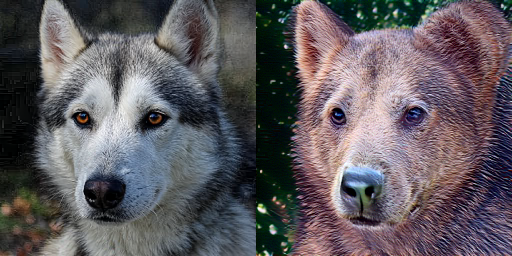

In [ ]:
#@title Dog face manipulation (256x256)
#@markdown You can use `imgs/dog1.png`~`imgs/dog4.png` as `img_path`.

dl.ensure_file_exists('14OG_o3aa8Hxmfu36IIRyOgRwEP6ngLdo', 'pretrained/afhq_dog_4m.pt')

img_path = 'imgs/dog1.png'  #@param {type:"string"}
edit_type = 'Bear' #@param['Bear', 'Hamster', 'Yorkshire Terrier', 'Nicolas Cage', 'Zombie', 'Venom', 'Smiling', 'Painting by Gogh']
degree_of_change = 1.0 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
dog_gdrive_ids = {'Bear':               ["1scbokdyRqvvz68DrD9zVONO-HFXaEFpn", "dog_bear_t500.pth"],
                  'Hamster':            ["1qLxztJ8Ngkv06v5bUyK5LgBmtgl5R8ST", "dog_hamster_t601.pth"],
                  'Yorkshire Terrier':  ["1-GJtENGDgamzU8zDqdfQL_n9umY7J7AO", "dog_yorkshire_t601.pth"],
                  'Nicolas Cage':       ["1hOl6k9Y-qVCIzMQ86M5-QbtqwVgiNDKA", "dog_nicolas_t601.pth"],
                  'Zombie':             ["1uEm93m_Eh4sQ9gwljShojsNHXFIN5JUI", "dog_zombie_t601.pth"],
                  'Venom':              ["10KkL9GhgEGqtlTsMjNRKVnJhv8Rpkpbm", "dog_venome_t601.pth"],
                  'Painting by Gogh':   ["1oL4IkNpIPz59zb2rCejmNzAGM1Ms6__a", "dog_gogh_t500.pth"],
                  }


gid = dog_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', dog_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step =  40#@param {type: "integer"}
n_test_step = 40 #@param [40]
args_dic = {
    'config': 'afhq.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0,
    'bs_test': 1,
    'model_path': model_path,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': 1,
    'align_face': 0,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(exp_dir, f"3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}_{model_path.split('/')[-1].replace('.pth','')}.png"))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid


Finished
return step t_0: 601


Downloading: "https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/celeba_hq.ckpt" to /root/.cache/torch/hub/checkpoints/celeba_hq.ckpt


  0%|          | 0.00/434M [00:00<?, ?B/s]

None is loaded.
checkpoint/pixar_t601.pth is loaded.


Inversion process :  98%|█████████▊| 39/40 [00:19<00:00,  1.96it/s]


Sampling type: DDIM with eta 0.0,  Steps: 6/601
Uniform skip type


Generative process 0: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]

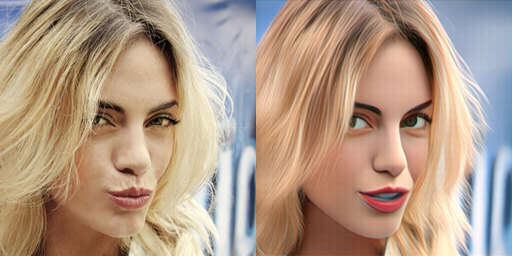

In [ ]:
#@title Human face manipulation (256x256)
#@markdown You can use `imgs/celeb1.png`\~`imgs/celeb4.png` as `img_path`.

#@markdown If you use your own custom image, please check `align_face` to align the face for the manipulation.
img_path = 'imgs/celeb1.png'  #@param {type:"string"}
align_face = False #@param {type:"boolean"}
edit_type = 'Pixar' #@param ['Pixar', 'Neanderthal','Sketch', 'Painting by Gogh', 'Tanned',  'With makeup', 'Without makeup', 'Female → Male']
degree_of_change = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
human_gdrive_ids = {'Pixar':                   ["1IoT7kZhtaoKf1uvhYhvyqzyG2MOJsqLe", "human_pixar_t601.pth"],
                    'Neanderthal':             ["1Uo0VI5kbATrQtckhEBKUPyRFNOcgwwne", "human_neanderthal_t601.pth"],
                    'Painting by Gogh':        ["1NXOL8oKTGLtpTsU_Vh5h0DmMeH7WG8rQ", "human_gogh_t601.pth"],
                    'Tanned':                  ["15Twto21spGLwiby7_yGO_xquFXtfJIAo", "human_tanned_t201.pth"],
                    'Female → Male':           ["1n1GMVjVGxSwaQuWxoUGQ2pjV8Fhh72eh", "human_male_t401.pth"],
                    'Sketch':                  ["1V9HDO8AEQzfWFypng72WQJRZTSQ272gb", "human_sketch_t601.pth"],
                    'With makeup':             ["1OL0mKK48wvaFaWGEs3GHsCwxxg7LexOh", "human_with_makeup_t301.pth"],
                    'Without makeup':          ["157pTJBkXPoziGQdjy3SwdyeSpAjQiGRp", "human_without_makeup_t301.pth"],
                    }


gid = human_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', human_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}_align{align_face}"
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step =  40#@param {type: "integer"}
n_test_step = 6 #@param [6]
args_dic = {
    'config': 'celeba.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0.0,
    'bs_test': 1,
    'model_path': model_path,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': 1,
    'align_face': align_face,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(exp_dir, f"3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}_{model_path.split('/')[-1].replace('.pth','')}.png"))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid

pretrained/512x512_diffusion.pt exists.
checkpoint/imagenet_watercolor_t601.pth exists.
return step t_0: 601
None is loaded.
checkpoint/imagenet_watercolor_t601.pth is loaded.
Latent exists.
Sampling type: DDIM with eta 0.0,  Steps: 12/601
Uniform skip type


Generative process 0: 100%|██████████| 12/12 [00:40<00:00,  3.34s/it]


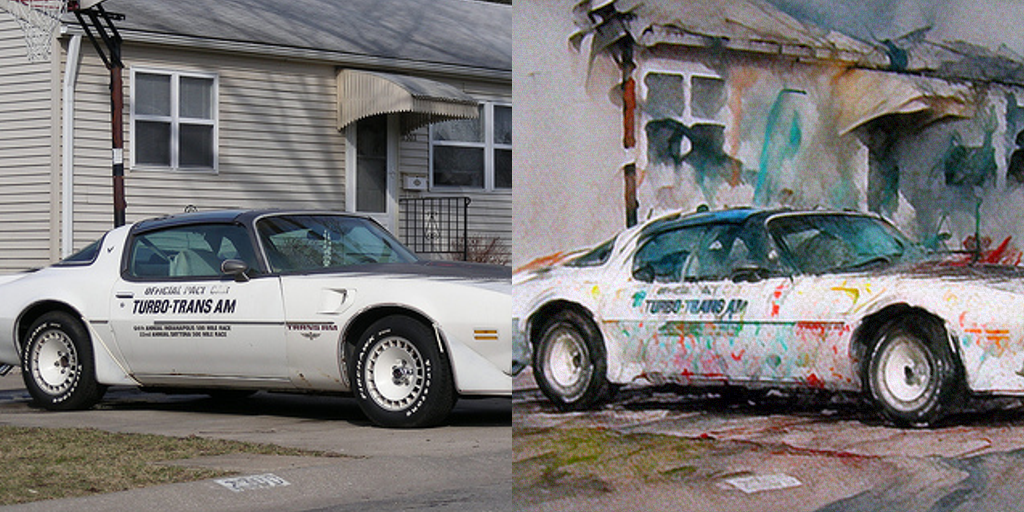

In [ ]:
#@title ImageNet Style Transfer (512x512)
#@markdown You can use `imgs/general1.png`\~`imgs/general4.png` as `img_path`.

if not os.path.exists('pretrained/512x512_diffusion.pt'):
  ! wget -P pretrained/ https://openaipublic.blob.core.windows.net/diffusion/jul-2021/512x512_diffusion.pt
else:
  print('pretrained/512x512_diffusion.pt exists.')



img_path = 'imgs/imagenet1.png'  #@param {type:"string"}
edit_type = 'Watercolor art' #@param ['Watercolor art', 'Pointillism art','Painting by Gogh', 'Cubism art']
degree_of_change = 1 #param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
imagenet_gdrive_ids = {'Watercolor art':   ["1l1vLwdL-6kC9jKcStASZ0KtX2OrmrSj6", "imagenet_watercolor_t601.pth"],
                       'Pointillism art':  ["1Am1Iii7jH986XQUuVaDs4v5s1h_acg0w", "imagenet_pointillism_t601.pth"],
                       'Painting by Gogh': ["1ZPeOvMpFStw8RXJga_0pWLJ7iIWEQIVY", "imagenet_gogh_t601.pth"],
                       'Cubism art':       ["1xEx4_MXvbvtSqLzn6z49RUnPDFoDv9Vm", "imagenet_cubism_t601.pth"],
                      }

gid = imagenet_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', imagenet_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step =  40#@param {type: "integer"}
n_test_step = 12#@param [12]
args_dic = {
    'config': 'imagenet.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0.0,
    'bs_test': 1,
    'model_path': model_path,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': 1,
    'align_face': 0,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(exp_dir, f"3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}_{model_path.split('/')[-1].replace('.pth','')}.png"))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid



# Generation of Images in Unseen Domain from Strokes
- Use the image path of samples in `./imgs` or your image by uploading it.
- If the distribution of the noisy image from the source unseen domain and the trained domains are not overlaped enough, the translation may fail. In other words, the source image need to be similar in terms of structure and shape.
- `n_inv_step` can be chosen in `[0, t_0]` where `t_0` is set depending on the finetuned models automatically  e.g. 40.
- `n_test_step` can be chosen in `[0, n_inv_step]` e.g. 6 or 40.
- `n_iter_forward` determine the iteration of the foward and generative process to tranlate the source image in the unseen domain to the image in the trained domain. It can be normally chosen between 1 and 12. This process is stochastic, so it will produce differenct result at each run.
- By increasing `n_result`, you can see multiple results from one input, but this require more run time.
- To make your own image strokes, you can use any painter application e.g. https://pixlr.com/kr/x/ .

checkpoint/pixar_t601.pth exists.
Original diffusion Model loaded.
Sampling type: DDIM with eta 0.0
Uniform skip type


Inversion process :  98%|█████████▊| 39/40 [00:17<00:00,  2.18it/s]


Original diffusion Model loaded.
Sampling type: DDIM with eta 0.0,  Steps: 40/601
Uniform skip type


Generative process 38: 100%|██████████| 40/40 [00:18<00:00,  2.15it/s]

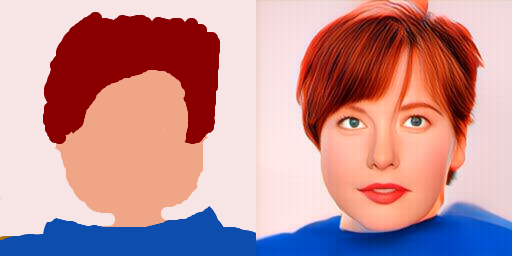

In [ ]:
#@title Stroke ➝ Unseen domain  (256x256)
#@markdown You can use `imgs/stroke1.png`\~`imgs/stroke4.png` as `img_path`.

img_path = 'imgs/stroke1.png'  #@param {type:"string"}
edit_type = 'Pixar' #@param ['Pixar', 'Neanderthal','Sketch', 'Painting by Gogh', 'Tanned',  'With makeup', 'Without makeup', 'Female → Male']
degree_of_change = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
human_gdrive_ids = {'Pixar':                   ["1IoT7kZhtaoKf1uvhYhvyqzyG2MOJsqLe", "human_pixar_t601.pth"],
                    'Neanderthal':             ["1Uo0VI5kbATrQtckhEBKUPyRFNOcgwwne", "human_neanderthal_t601.pth"],
                    'Painting by Gogh':        ["1NXOL8oKTGLtpTsU_Vh5h0DmMeH7WG8rQ", "human_gogh_t601.pth"],
                    'Tanned':                  ["15Twto21spGLwiby7_yGO_xquFXtfJIAo", "human_tanned_t201.pth"],
                    'Female → Male':           ["1n1GMVjVGxSwaQuWxoUGQ2pjV8Fhh72eh", "human_male_t401.pth"],
                    'Sketch':                  ["1V9HDO8AEQzfWFypng72WQJRZTSQ272gb", "human_sketch_t601.pth"],
                    'With makeup':             ["1OL0mKK48wvaFaWGEs3GHsCwxxg7LexOh", "human_with_makeup_t301.pth"],
                    'Without makeup':          ["157pTJBkXPoziGQdjy3SwdyeSpAjQiGRp", "human_without_makeup_t301.pth"],
                    }


gid = human_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', human_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
exp_dir = f"runs/S2U_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)

# Test arg, config
n_inv_step =  40#@param {type: "integer"}
n_test_step = 40 #@param {type: "integer"}
n_iter_forward =  5 #@param {type: "integer"}
n_result =  1#@param {type: "integer"}
args_dic = {
    'config': 'celeba.yml',
    't_0': t_0,
    'n_inv_step': int(n_inv_step),
    'n_test_step': int(n_test_step),
    'sample_type': 'ddim',
    'eta': 0.0,
    'bs_test': n_result,
    'model_path': model_path,
    'img_path': img_path,
    'deterministic_inv': 1,
    'hybrid_noise': 0,
    'n_iter': n_iter_forward,
    'image_folder': exp_dir,
    'model_ratio': degree_of_change,
    'align_face': 0,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.unseen2unseen()


# Result
print()
img = Image.open(os.path.join(exp_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
img = Image.open(os.path.join(exp_dir, f"4_gen_t{t_0}_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}.png"))
img = img.resize((int(img.width), int(img.height)))
grid.paste(img, (int(img.width//n_result), 0))
grid